# ONS Geography Portal REST API
## Overview
This notebook gives examples of requesting geographic datasets from the [ONS Geography Portal](https://geoportal.statistics.gov.uk/) through its REST interface, using Python. 

There are a number of endpoints giving access to ONS Geographic data. This tutorial will focus on building customised queries where the user knows the endpoint/data layer they require, and are only interested in requesting a subset of the data using optional arguments. 

## Prerequisites
- Basic knowledge of Python
- Basic knowledge of [REST APIS](https://www.techtarget.com/searchapparchitecture/definition/RESTful-API#:~:text=A%20RESTful%20API%20is%20an,deleting%20of%20operations%20concerning%20resources)
- Basic knowledge of the Geopandas Python library.
For this notebook to work, you will need to have geopandas installed - ONS installation instructions [here](https://onsgeo.github.io/geospatial-training/)

### Python Requests library
One of the most common methods of accessing REST APIs in Python is through the requests library. This may need to be installed in your environment using the command line (<code>pip install requests</code>), or in your notebook as below (remove the comment before running the cell)


In [ ]:
# !pip install requests

In [ ]:
#Import libraries
import geopandas as gpd
import json
import requests
import urllib


## Part One: Getting boundary data
### Get available layers
The starting point to building a query is to check what datasets are available, find their names in the portal, and then recursively searching into each of the datasets' directories to see what layers are available.

### 1.1 Getting avaialable datasets and layers available using REST

In [ ]:
BASE_URL = "https://ons-inspire.esriuk.com/arcgis/rest/services/?f=json" #Note the format ('f=') of the response is json
r = requests.get(BASE_URL) 
#Status 200 means the request was successful (404 means the endpoint is invalid/removed)
print(r.status_code)
#Content returned in json (Datasets in root folder)
print(f'SERVICES AVAILABLE AT {BASE_URL}')
print(json.dumps(r.json(), indent=2)) #All we need is r.json() but the rest makes the output easier to read

#The query can be built up by adding 'directories' to the url (herethe Postcodes dataset is included to see what's available)
BASE_URL_POSTCODES = "https://ons-inspire.esriuk.com/arcgis/rest/services/Postcodes/?f=json"
r_postcodes = requests.get(BASE_URL_POSTCODES)
print(f'POST CODE SERVICES AVAILABLE')
print(json.dumps(r_postcodes.json(), indent=2))


### 1.2 Building a query manually
The above method can become confusing if you are not familiar with the datasets avaiable, their names or locations. In some cases, the datasets listed above are no longer available, which would result in an error in your code.

An easier method would be to go to the ONS Geography Portal, navigate to your required layer to get its URL, and then build the query from there.

1. Navigate to the [ONS Geography Portal](https://geoportal.statistics.gov.uk/)
2. Select a dataset and layer - here we select [Boundaries>>Administrative Boundaries>>Local Authority Districts>>2021 Boundaries>>Local Authority Districts (December 2021) GB BFC](https://geoportal.statistics.gov.uk/datasets/ons::local-authority-districts-december-2021-gb-bfc/explore?location=54.942825%2C-3.265847%2C6.00)
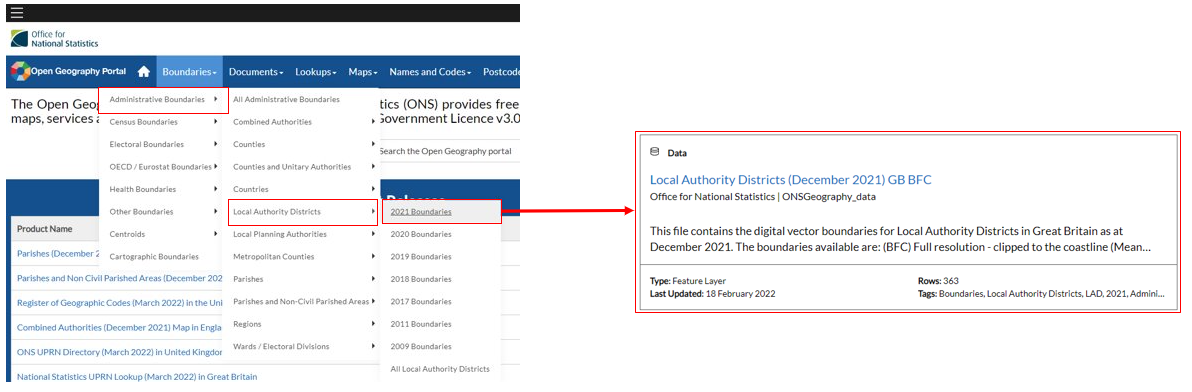

3. On the bottom of the interface of the map that opens, click "I want to use this", and then View API Resources>>[Open in API Explorer](https://geoportal.statistics.gov.uk/datasets/ons::local-authority-districts-december-2021-gb-bfc/api)
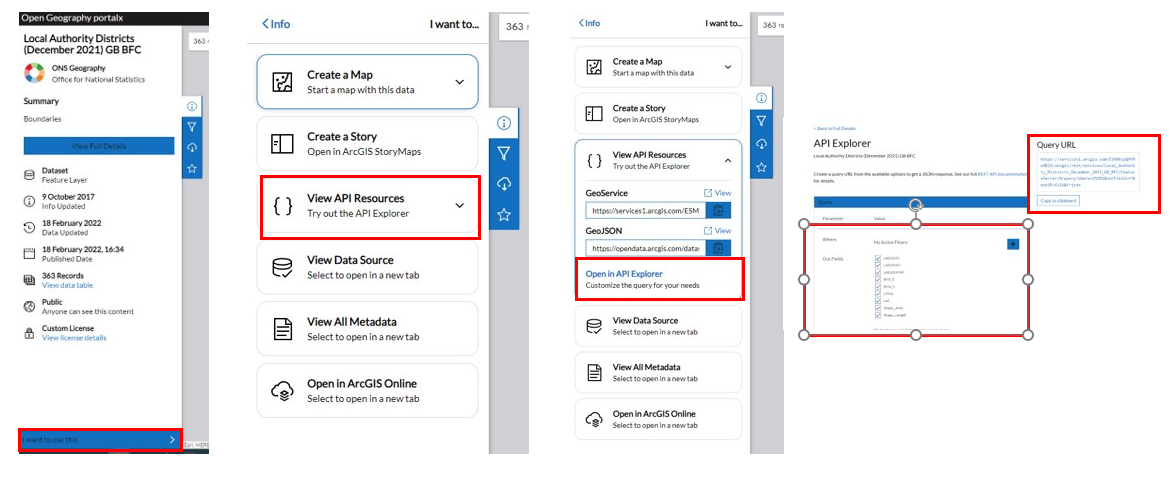

4. The main information that we need on this page is the URL to the dataset (QUERY URL) up to and including **'query?'** - https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/Local_Authority_Districts_December_2021_GB_BFC/FeatureServer/0/query?

From here, we can build the query, either using the fields shown in the 'Query' box, or using geometries. 


### 1.3 Building a query using attribute values
Although all the data can be queried using the above URL, this may be more than is needed. By completing a parameters dictionary, the data in the request can be filtered. In the following cells, the Local Authority Layer is queried using attributes, in this case, where the LAD21NM field meets a condition ("LAD21NM = 'Fareham'"), using an SQL-like statement.


In [ ]:
##Root url to layer
BASE_URL = 'https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/Local_Authority_Districts_December_2021_GB_BFC/FeatureServer/0/query?'

#Parameter dictionary (Note that not all of these are required). All optional/required parameters can be found at https://developers.arcgis.com/rest/services-reference/enterprise/query-feature-service-layer-.htm
params = {
    'where': "LAD21NM = 'Fareham'", #SQL-like statement for fields. This can have multiple values, e.g. 'LAD21NM in (Fareham, Newport)'
    'outFields': 'LAD21CD, LAD21NM', #This is selecting 2 fields only. Select ALL fields using '*'
    'outSR': 27700, #Coordinate reference system projected to British National Grid
    'f': 'geojson' #Ouput format in GeoJSON, which can then be converted to dataframe later
    }
#encode params dicionary to a query string and concatenate to BASE_URL
url = BASE_URL + urllib.parse.urlencode(params)
#The data can be view by pasting the url into a browser
print(url)

In [ ]:
# or the data can be retrieved in Python
r = requests.get(url=url) 
if r.status_code == 200: #If the request is successful
    data = r.json() #Assign geojson in the response to data
else:
    print('There was a problem returning the data - ErrorCode: ' + r.status_code)

**The response can then be converted to a GeoDataFrame and saved as a shapefile or GeoPackage**

In [ ]:
gdf = gpd.GeoDataFrame.from_features(data, crs=27700)
display(gdf)
gdf.plot()

# The dataframe can be saved to GeoPackage
#gdf.to_file(<GEOPACKAGE_NAME>.gpkg, layer=<LAYER_NAME>, driver="GPKG")

# Or it can be saved to Shapefile
#gdf.to_file(<SHAPEFILE_NAME>.shp)

### 1.4 Building a query using geometries
Instead of querying the layers where an attribute is equal to a value, a spatial intersection between a query geometry and that of the layer being queried can also be used. In the following cells, the geometric envelope (bounding box) of the Fareham polygon made above (coordinates of bottom left corner and top right corner) is used to make an intersection of the same Local Authority layer. In this case, because the Fareham envelope intersects its neighbours, multiple polygons are returned. **Note that the example below uses .total_bounds of the initial dataframe read in. This does not always need to be used as the envelope. You just need to define a rectangle with its bottom left and top right latitude and longitude values). print(fareham_env) below to see this format.**

In [ ]:
#Instead of filtering the data by attributes, it can be filtered by envelope geometry
fareham_env = gdf[gdf.LAD21NM == 'Fareham'].total_bounds #This is the bounding box of the geometry initially read in 
#Make params object again
params = {
    'outFields': 'LAD21CD, LAD21NM',
    'geometry': f'{fareham_env[0]}, {fareham_env[1]}, {fareham_env[2]}, {fareham_env[3]}', #Coordinates of extent
    'geometryType': 'esriGeometryEnvelope',
    'inSR': 27700, #Coordinate reference system of input geometry (envelope)
    'outSR': 27700, #Coordinate reference system projected to British National Grid
    'f': 'geojson'    
}

url = BASE_URL + urllib.parse.urlencode(params)
r = requests.get(url=url)
if r.status_code == 200:
    data = r.json()
else:
    print('There was a problem returning the data - ErrorCode: ' + r.status_code)
    
#Note that in this case any boundaries spatially intersecting the envelope are returned
gdf = gpd.GeoDataFrame.from_features(data, crs=27700)
display(gdf)
gdf.plot()



## Part Two: Getting Postcode data
As with polygon data, point data can also be requested - in this case postcode centroids from [Postcodes>>National Statistics Postcode Lookup (NSPL)>>Latest Centroid>>NSPL Latest Centroids](https://geoportal.statistics.gov.uk/datasets/ons::nspl-latest-centroids/explore?location=54.650000%2C-2.850000%2C5.88). 
As before, the points can be selected where they meet a certain value in their fields, or using spatial functions.

### 2.1 Select Postcodes by attribute
NOTE The change in the 'where' statement. In this case, the request is querying using the "like" SQL clause (WHERE pcd starts with 'PO167'). For more information on building SQL queries with wildcards see [here](https://www.w3schools.com/sql/sql_like.asp). 

In [ ]:
##Root url to layer (again built in the API Explorer for the layer)
BASE_URL = 'https://ons-inspire.esriuk.com/arcgis/rest/services/Postcodes/NSPL_Latest_Centroids/MapServer/0/query?'
#Parameter dictionary (Note that not all of these are required)
params = {
    'where': "pcd like 'PO167%'", #SQL-like statement for fields - This clause means find any values that start with PO167
    'outFields': 'pcd, cty, LAUA, WARD, CTRY', #This is selecting 5 fields only. Select ALL fields using '*'
    'outSR': 27700, #Coordinate reference system projected to British National Grid
    'f': 'geojson' #Ouput format in GeoJSON, which can then be converted to dataframe later
    }
#params = {'where': "LAD21NM = 'Fareham'", 'outFields': 'LAD21CD, LAD21NM', 'outSR': 27700, 'f': 'geojson'}
#uncode params dicionary to a query string and concatenate to BASE_URL
url = BASE_URL + urllib.parse.urlencode(params)
#The data can be view by pasting the url into a browser
print(url)

In [ ]:
url = BASE_URL + urllib.parse.urlencode(params)
r = requests.get(url=url)
if r.status_code == 200:
    data = r.json()
else:
    print('There was a problem returning the data - ErrorCode: ' + r.status_code)
    
#Note that in this case any boundaries intersecting the envelope are returned
gdf = gpd.GeoDataFrame.from_features(data, crs=27700)
display(gdf)
gdf.plot()

### 2.1 Select postcodes using a geometry
In this final part, the point in the first row of the above dataframe is buffered by 100m, and then its envelope/bounds are calculated and all points within these bounds are selected. The 'spatialRel' parameter in the dictionary below specifies that points are selected where the envelope 'contains' them (intersect is default). Please see [here](https://developers.arcgis.com/rest/services-reference/enterprise/query-feature-service-layer-.htm) and search for 'spatialRel' for futher relationships that can be chosen. For an explanation on spatial relationships, see [here](https://desktop.arcgis.com/en/arcmap/latest/extensions/data-reviewer/types-of-spatial-relationships-that-can-be-validated.htm). NOTE that in most cases, the default (intersects) should serve most purposes. Further spatial relationship operations can be carried out using geopandas once the data has been received - see [here](https://geopandas.org/en/stable/docs/user_guide/set_operations.html).

In [ ]:
buffer_env = gdf[gdf['pcd'] == 'PO167AA'].buffer(100).total_bounds #First row's geometry selected and buffered by 100m

params = {
    'outFields': 'pcd, cty, LAUA, WARD, CTRY',
    'geometry': f'{buffer_env[0]}, {buffer_env[1]}, {buffer_env[2]}, {buffer_env[3]}', #Coordinates of extent
    'geometryType': 'esriGeometryEnvelope',
    'spatialRel': 'esriSpatialRelContains', #Contains relationship - See above cell for other relationships available
    'inSR': 27700, #Coordinate reference system of input geometry (envelope)
    'outSR': 27700, #Coordinate reference system projected to British National Grid
    'f': 'geojson'    
}

url = BASE_URL + urllib.parse.urlencode(params)
r = requests.get(url=url)
if r.status_code == 200:
    data = r.json()
else:
    print('There was a problem returning the data - ErrorCode: ' + r.status_code)
    
#Note that in this case any boundaries intersecting the envelope are returned
gdf = gpd.GeoDataFrame.from_features(data, crs=27700)
display(gdf)
gdf.plot()

## Part Three: Extra tips

### 3.1 CSV/Tabular Data
Whilst there may be a use case for querying many other spatial data on the portal, in some instances (UPRN Lookups or Standard Area Measurements), this data is only held in csv format on the server, and it is not possible to query this using REST. In these instances, these data should be read from csv into Pandas dataframes, and then joined where appropriate to corresponding spatial dataframes.

Tabular data can also be queried from these layers by omitting the geometries from the response. This may speed up your response times if you do not need the geometries. For example, for the boundary data, the geometries could be omitted by defining the parameter object as follows:
```python
    params = {
    'outFields': 'LAD21CD, LAD21NM',
    'geometry': f'{fareham_env[0]}, {fareham_env[1]}, {fareham_env[2]}, {fareham_env[3]}', #Coordinates of extent
    'geometryType': 'esriGeometryEnvelope',
    'returnGeometry': False, #Default is True
    'inSR': 27700, #Coordinate reference system of input geometry (envelope)
    'outSR': 27700, #Coordinate reference system projected to British National Grid
    'f': 'geojson'    
}
```

### 3.2 Storing commonly used urls
If your code makes regular use of different layers in the REST API, rather than building queries through the API explorer, it may be useful to store a dictionary in a file, that can be called when needed:

```python
  api_urls = {
        'ADMIN_BOUNDARIES': {
            'Combined_Authorites_December_2021_EN_BFC': {
                'Combined_Authorities_(December_2021)_Full_Clipped_Boundaries_EN': 
                    "https://ons-inspire.esriuk.com/arcgis/rest/services/Administrative_Boundaries/Combined_Authorites_December_2021_EN_BFC/FeatureServer/0/query?",
                'Combined_Authorities_(December_2021)_Full_Extent_Boundaries_EN': 
                    'https://ons-inspire.esriuk.com/arcgis/rest/services/Administrative_Boundaries/Combined_Authorites_December_2021_EN_BFE/FeatureServer/0/query?'
            },
        },
        'CENSUS_BOUNDARIES': {
            'Built_Up_Area_Sub_Divisions_December_2011_Boundaries_V2': {
                'Built_Up_Area_Sub_Divisions_(2011)_Generalised_Grid_Boundaries_in_England_and_Wales': 
                    'https://ons-inspire.esriuk.com/arcgis/rest/services/Census_Boundaries/Built_Up_Area_Sub_Divisions_December_2011_Boundaries_V2/FeatureServer/0/query?'
            }
    ...
        }
    ...
    }
```
... and so on. URLs can then be queried from this nested structure using:

```python 
url = api_urls['ADMIN_BOUNDARIES']['Combined_Authorites_December_2021_EN_BFC']['Combined_Authorities_(December_2021)_Full_Clipped_Boundaries_EN']
```

Such an object can be built and stored prograamatically by recursively walking through the directories as shown in Section 1.1.